In [1]:
import json
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from inline_sql import sql
from shapely.geometry import shape

In [2]:
pozos = pd.read_csv("capitulo-iv-pozos.csv")
produccion = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2024.csv")
# yacimientos = pd.read_csv("produccin-hidrocarburos-yacimientos.csv")

C:\Users\carri\AppData\Local\Temp\ipykernel_13328\2280891875.py:2: DtypeWarning: Columns (16,36) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2024.csv")


In [3]:
id_coords = pozos[['idpozo', 'geojson']]
coordenadas = id_coords['geojson'].apply(json.loads)
coordenadas = coordenadas.apply(lambda x: x['coordinates'])
coordenadas = pd.DataFrame(coordenadas.tolist(), columns=['lon', 'lat'])
coordenadas = coordenadas[['lat', 'lon']]

id_coords.shape[0], coordenadas.shape[0]

(84332, 84332)

In [4]:
id_coords = pd.concat([id_coords['idpozo'], coordenadas], axis=1)

In [5]:
prods = sql^ """
             SELECT idpozo, SUM(prod_pet) AS prod_pet, SUM(prod_gas) AS prod_gas
             FROM produccion
             GROUP BY idpozo
             """

In [6]:
coords_prod = sql^ """
                   SELECT lat, lon, prod_pet, prod_gas
                   FROM id_coords
                   NATURAL JOIN prods
                   """
coords_prod

,lat,lon,prod_pet,prod_gas
0,-45.591133,-68.287853,740.32,82.58
1,-45.592025,-68.292019,0.00,0.00
2,-45.590244,-68.283878,984.66,54.90
3,-45.594069,-68.289483,577.26,43.06
4,-45.594450,-68.294475,298.50,20.51
...,...,...,...,...
82183,-38.318435,-68.715848,2587.30,617.05
82184,-38.357840,-68.738945,295.58,71.11
82185,-45.739104,-67.639703,55.69,0.00
82186,-37.993570,-67.781680,0.00,0.00


In [7]:
# yacimientos['geojson_dict'] = yacimientos['geojson'].apply(json.loads)
 # yacimientos['yac'] = yacimientos['geojson_dict'].apply(shape)
  # gdf = gpd.GeoDataFrame(yacimientos, geometry='yac', crs="EPSG:4326")
   # gdf.to_file("./shapefiles/shapefile_yac/yacimientos.shp")

In [8]:
def mapa_argentina_pozos(coords_prod):
    provincias_path = "./shapefiles/shapefile_provincial/linea_de_limite_070111.shp"
    provincias = gpd.read_file(provincias_path)

    pais_path = "./shapefiles/shapefile_pais/pais.shp"
    pais = gpd.read_file(pais_path)

    mar_path = "./shapefiles/shapefile_maritimo/linea_limite_maritimos.shp"
    mar = gpd.read_file(mar_path)
    
    lat = coords_prod['lat']
    lon = coords_prod['lon']
    pet = coords_prod['prod_pet']
    gas = coords_prod['prod_gas']

    pet = (pet-min(pet))/(max(pet)-min(pet))
    gas = (gas-min(gas))/(max(gas)-min(gas))
    
    fig, ax = plt.subplots(figsize=(7,11))
    mar.plot(ax=ax, color='steelblue', linewidths=0.5)
    pais.plot(ax=ax, color='gainsboro', edgecolor='black', linewidth=0.8)
    provincias.plot(ax=ax, color='gray', linewidth=0.5)
    ax.scatter(lon, lat, s=pet*1000, color='plum', alpha=0.2, linewidths=0.3)
    ax.scatter(lon, lat, s=0.1, color='indigo', linewidths=0)
    ax.set(xticks=[], yticks=[])
    ax.set_xlim(-74, -25)
    ax.set_ylim(-89, -20)
    plt.savefig('mapa_pozos_pet.png', dpi=300, bbox_inches='tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    fig, ax = plt.subplots(figsize=(7,11))
    mar.plot(ax=ax, color='steelblue', linewidths=0.5)
    pais.plot(ax=ax, color='gainsboro', edgecolor='black', linewidth=0.8)
    provincias.plot(ax=ax, color='gray', linewidth=0.5)
    ax.scatter(lon, lat, s=gas*1000, color='lightcoral', alpha=0.2, linewidths=0.3)
    ax.scatter(lon, lat, s=0.1, color='maroon', linewidths=0)
    ax.set(xticks=[], yticks=[])
    ax.set_xlim(-74, -25)
    ax.set_ylim(-89, -20)
    plt.savefig('mapa_pozos_gas.png', dpi=300, bbox_inches='tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

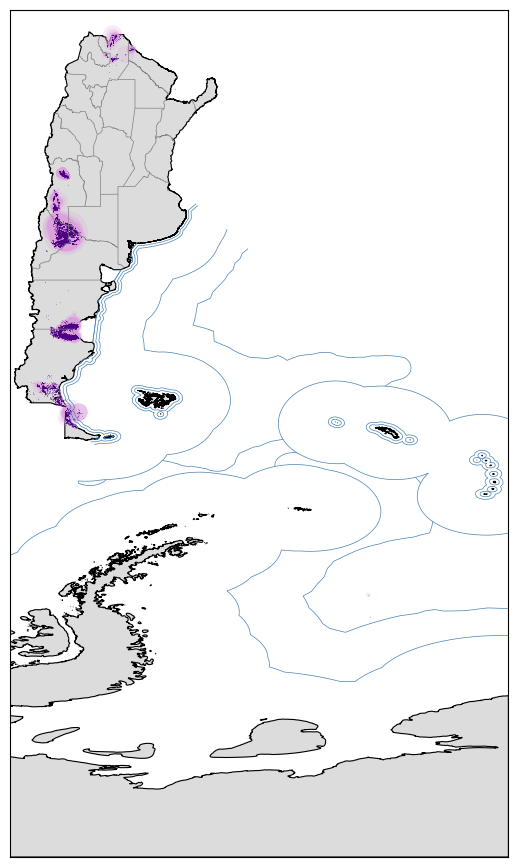

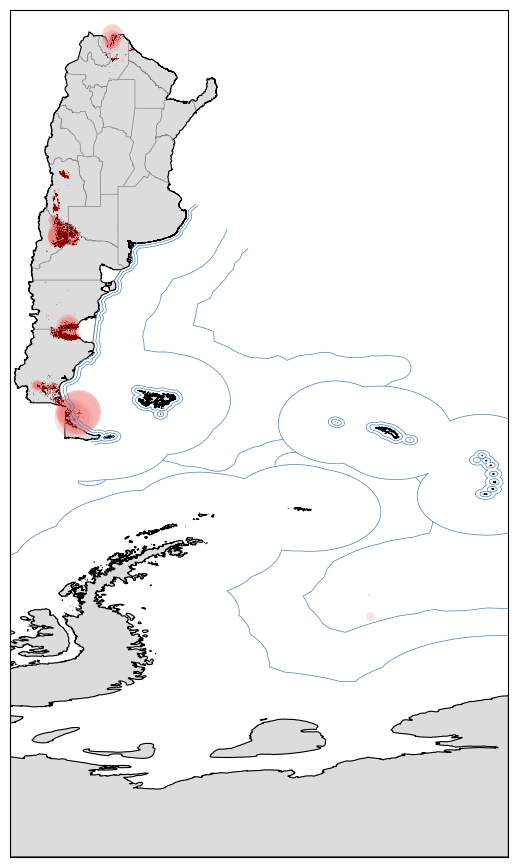

In [9]:
mapa_argentina_pozos(coords_prod)